#### Module Imports

In [1]:
import os
import time
from tqdm import tqdm
import numpy as np

import torch
import torch.optim as optim
from ema_pytorch import EMA

from networks import Generator, Discriminator
from data import get_dataloader
from viz import visualize_batch, show_tensor_shape, generate_and_save_frame
from diff_augment import DiffAugment
from utilities import initialize_weights, get_positive_labels

#### Hyperparameter Configuration

In [2]:
# Set fundamental parameters
data_path = os.path.join(os.getcwd(), 'data')
outdir = "results"
image_size = 64
num_channels = 3
batch_size = 256

# Set Generator hyperparameters
latent_dim = 256
g_feat_map_size = 64
ema_G_smoothing = 0.995  # average over the last ~10 epochs
ema_G_update_after = 100  # start averaging after the first 5 epochs
ema_G_update_every = 1

# Set Discriminator hyperparameters
d_feat_map_size = 64
dropout_prob = 0.1

# Set optimization hyperparameters
lr_G = 0.002
lr_D = 0.0005
beta1 = 0.7
beta2 = 0.999

# Set training hyperparameters
n_epochs = 500
save_iter = 10
augmentation_policy = "color,translation"  #,cutout
smoothing_ratio = 0.6
flip_ratio = 0.05

#### Dataset Download and Preprocessing

Size of the dataset: 16185
Using 12 workers
Shape of batch of data: torch.Size([256, 3, 64, 64])


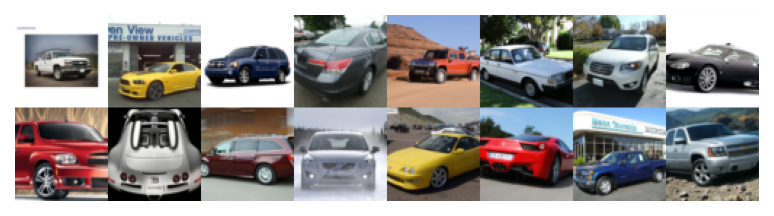

In [3]:
# Get data loader and visualize a batch of images
dataloader = get_dataloader(data_path, image_size, batch_size)
sample_batch = next(iter(dataloader))[0]
print(f"Shape of batch of data: {sample_batch.shape}")
visualize_batch(sample_batch[:16])

# Create the output directory
os.makedirs(outdir, exist_ok=True)

#### Generator and Discriminator Initialization

Using device: cuda
===== Generator =====
(B, C, W, H): (1, 256, 1, 1)
(B, C, W, H): (1, 512, 4, 4)
(B, C, W, H): (1, 256, 8, 8)
(B, C, W, H): (1, 128, 16, 16)
(B, C, W, H): (1, 64, 32, 32)
(B, C, W, H): (1, 3, 64, 64)

===== Discriminator =====
(B, C, W, H): (1, 3, 64, 64)
(B, C, W, H): (1, 64, 32, 32)
(B, C, W, H): (1, 128, 16, 16)
(B, C, W, H): (1, 256, 8, 8)
(B, C, W, H): (1, 512, 4, 4)
(B, C, W, H): (1, 1, 1, 1)


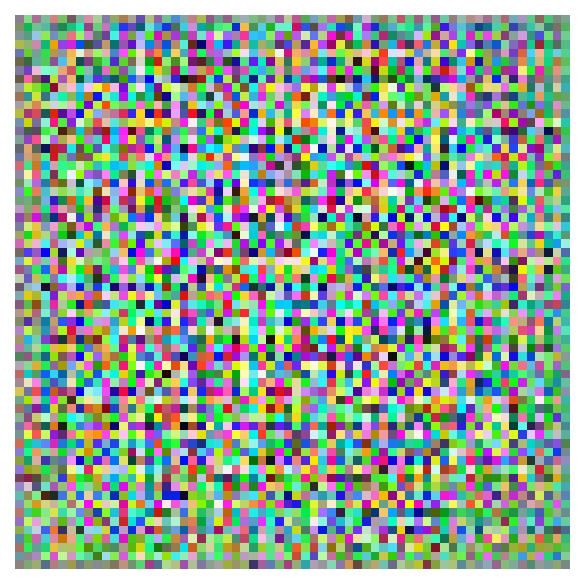

In [4]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Initialize the generator
G = Generator(image_size, latent_dim, g_feat_map_size, num_channels).to(device)

# Show the shape of the tensor after each layer in the generator
print("===== Generator =====")
x = torch.randn(1, latent_dim, 1, 1).to(device)
show_tensor_shape(x)
for i in range(len(G.model)):
    x = G.model[i](x)
    show_tensor_shape(x)

# Visualize the generated images
visualize_batch(x.detach())


# Initialize the discriminator
D = Discriminator(image_size, d_feat_map_size, num_channels, dropout_prob).to(device)

# Show the shape of the tensor after each layer in the discriminator
print("\n===== Discriminator =====")
show_tensor_shape(x)
for i in range(len(D.model)):
    x = D.model[i](x)
    show_tensor_shape(x)

#### Training Setup

In [5]:
# Initialize the criterion for the GAN loss
criterion = torch.nn.BCELoss() 

# Initialize generator and discriminator optimizers
optimizer_G = optim.Adam(G.parameters(), lr=lr_G, betas=(beta1, beta2))
optimizer_D = optim.Adam(D.parameters(), lr=lr_D, betas=(beta1, beta2))

# Initialize weights
_ = G.apply(initialize_weights)
_ = D.apply(initialize_weights)

# Initialize the exponential moving average for the generator
ema_G = EMA(G, beta=ema_G_smoothing, update_after_step=ema_G_update_after, update_every=ema_G_update_every)

#### GAN Training

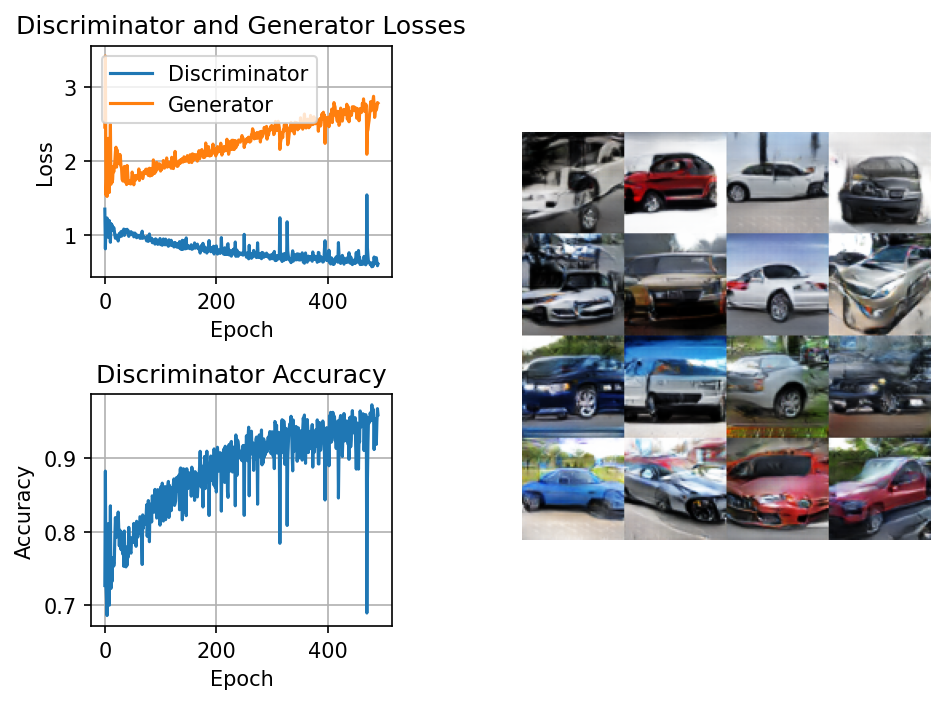

100%|██████████| 64/64 [00:26<00:00,  2.39it/s]

Finished in 223.5 min


In [6]:
print("Starting Training Loop...")

# Fixed noise for visualization
fixed_noise = torch.randn(16, latent_dim, 1, 1, device=device)

# Metrics to keep track of the losses and accuracy
metrics = {"G_loss": list(), "D_loss": list(), "D_acc": list()}
tstart = time.time()
n_frame = 0

for epoch in range(n_epochs):
    # Keep track of losses and accuracy for each batch
    batch_G_losses = []
    batch_D_losses = []
    batch_D_accs = []

    # Loop over batches of real data
    for data, _ in tqdm(dataloader, total=len(dataloader)):
        # Move data to device and get batch size
        data = data.to(device)
        b_size = data.size(0)

        ##############################
        # Discriminator training     #
        ##############################

        D.zero_grad()

        # Forward pass real batch through Discriminator
        augmented_data = DiffAugment(data, augmentation_policy)
        D_pred = D(augmented_data)  # shape: (b_size, )

        # Measure accuracy for the positive batch
        acc_pos = (D_pred > 0.5).sum().item() / D_pred.size(0)

        # Generate labels with smoothing and flipping
        labels = get_positive_labels(b_size, device, smoothing_ratio, flip_ratio)

        # Loss on the real data
        loss_on_real_data = criterion(D_pred, labels)
        loss_on_real_data.backward()

        # Generate fake data
        latent_vectors = torch.randn(b_size, latent_dim, 1, 1, device=device)
        fake_data = G(latent_vectors)

        # Get predictions from the Discriminator for fake data
        augmented_fake_data = DiffAugment(fake_data, augmentation_policy).detach()
        D_pred = D(augmented_fake_data)  # shape: (b_size, )

        # Measure accuracy for the negative batch
        acc_neg = (D_pred < 0.5).sum().item() / D_pred.size(0)

        # Loss on fake data
        labels.fill_(0)  # 0 is the label for fake images
        loss_on_fake_data = criterion(D_pred, labels)
        loss_on_fake_data.backward()

        # Calculate the total loss and update the Discriminator
        total_loss = loss_on_real_data + loss_on_fake_data
        optimizer_D.step()

        ##############################
        # Generator training         #
        ##############################

        G.zero_grad()

        # Get predictions from the Discriminator for generated fake data
        augmented_fake_data = DiffAugment(fake_data, augmentation_policy)
        D_pred = D(augmented_fake_data)  # shape: (b_size, )

        # Calculate the loss from the Discriminator prediction
        labels.fill_(1)  # 1 is the label for real images (we want to fool the Discriminator)
        loss_on_fake_G = criterion(D_pred, labels)

        # Calculate gradients and update the Generator
        loss_on_fake_G.backward()
        optimizer_G.step()

        # Update the Exponential Moving Average copy of the Generator
        ema_G.update()

        # Save all losses and accuracy
        batch_G_losses.append(loss_on_fake_G.item())
        batch_D_losses.append(total_loss.item())
        batch_D_accs.append((0.5 * (acc_pos + acc_neg)))

    # Take the mean over the epoch
    metrics["G_loss"].append(np.mean(batch_G_losses))
    metrics["D_loss"].append(np.mean(batch_D_losses))
    metrics["D_acc"].append(np.mean(batch_D_accs))

    # Save visualization frame at specified intervals
    if epoch % save_iter == 0:
        n_frame = generate_and_save_frame(G, fixed_noise, metrics, outdir, n_frame)

print(f"Finished in {(time.time() - tstart)/60:.1f} min")

#### Generated Image Visualization

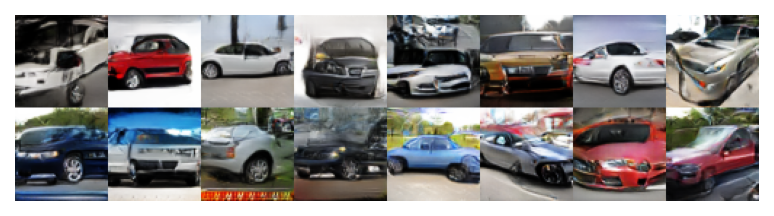

In [7]:
# Visualize the generated images
generated_images = ema_G(fixed_noise)
visualize_batch(generated_images)